Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

!pip install gym  torch
!apt-get install python-opengl ffmpeg -y 
!apt install xvfb -y 
!pip install pyvirtualdisplay  
!pip install piglet 
!pip install gym[box2d] 
!pip install tensorflow 


In [1]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


In [2]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
# import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def make_noise():
    mu, sigma = 0, 0.05 # mean and standard deviation
    return np.random.normal(mu, sigma, 1)[0]

def plot(frame_idx, rewards, losses):
#     clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


# My Code

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import os

In [6]:
class defaultActions:
    def __init__(self):

        self.main = [[1    , "Main strong"],
                     [0.51 ,"Main slow"],
#                      [0.75 , "Main meduim"],
                     [0 , "Main off"]
                    ]
        self.left_right = [
                        [0, "Left Right off"],
#                         [-0.5 , "Left slow"],
#                         [-0.75  , "Left meduim"],
                        [-1 , "Left strong"],
                        
#                         [0.5 , "Right slow"],
#                         [0.75  , "Right meduim"],
                        [1 , "Right strong"],
                        ]
        self.all_actions = {}
        i = 0  
        for main_eng in self.main:
            for sec_eng in self.left_right:
#                 print (f"a{i},act:[{main_eng[0]},{sec_eng[0]},{main_eng[1]} {sec_eng[1]}]")
                self.all_actions[i] = [[main_eng[0],sec_eng[0]] , f"{main_eng[1]}, {sec_eng[1]}"]
                i+=1
        
    def get_full_action(self,id):
        return self.all_actions[id]

    def get_action(self,id,add_noise=False):
        if add_noise :
            return [self.all_actions[id][0][0]+make_noise(), self.all_actions[id][0][1]+make_noise()]
        else:
            return self.all_actions[id][0]

    def get_description(self,id):
        return self.all_actions[id][1]
    def get_action_count(self):
        return len(self.all_actions)
actions = defaultActions()


In [7]:
class model(nn.Module):
    def __init__(self, layers, name=""):
        super(model, self).__init__()
        self.name = ""
        self.layers = layers
        self.features = nn.Sequential(*layers)


    def name(self):
        return self.name

    def model_summery(self):
        return self.features.summary()

    def forward(self, x):
        return self.features(x)

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        
#         ret =  random.sample(self.memory, batch_size)
        random.shuffle(self.memory)
        self.position-=1
        
        return [self.memory.pop()]

    def __len__(self):
        return len(self.memory)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [10]:
input_size = 8
h1 = 32
h2 = 32
h3 = 32
h4 = 32
h5 = 32
output_size = actions.get_action_count()
layers = [nn.Linear(input_size,h1) ,nn.ReLU(inplace=True), #, nn.BatchNorm1d(h1)
         nn.Linear(h1,h2) ,nn.ReLU(inplace=True),
#          nn.Linear(h2,h3) ,nn.ReLU(inplace=True),
#          nn.Linear(h3,h4) , nn.ReLU(inplace=True),
#          nn.Linear(h4,h5) ,nn.ReLU(inplace=True),
         nn.Linear(h5,output_size),nn.ReLU(inplace=True) # , nn.BatchNorm1d(output_size)
         ]
for x in layers:
    if isinstance(x, nn.Linear):
        nn.init.normal_(x.weight, mean=0, std=1.0)


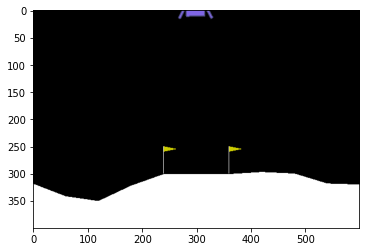

In [11]:
# Box2d Environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))


In [12]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=",a) 
state = env.reset()
print(state)   

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[-0.00544367  1.4062291  -0.55140024 -0.2085015   0.00631466  0.12490054
  0.          0.        ]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

In [13]:
DF = 0.99 #discount_factor
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 200
max_iterations = 5000
steps_done = 0
TARGET_UPDATE = 10
BATCH_SIZE =40
memory = ReplayMemory(10000)
# torch.autograd.set_detect_anomaly(True)
#mytestmodel.zero_grad()


In [14]:
policy_net =  model(layers).to(device)
target_net =  model(layers).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
# policy_net = pickle.load(open(f"model.pkl", "rb"))
# target_net = pickle.load(open(f"model.pkl", "rb"))

model(
  (features): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=9, bias=True)
    (5): ReLU(inplace=True)
  )
)

In [22]:
def run_episode(train=True,DF = 0.98 ,max_iterations = 3000,print_debug=2,print_game=False,just_random = False):
    global steps_done
    env = gym.make('LunarLanderContinuous-v2')
    env.reset()
    env = wrap_env(env)
    done = False
    iter = 0

    observation = state = env.reset()
    done = False
    action = 1
    TotalReward = 0
    TotalLoss=0
    df = DF
    while not done and iter < max_iterations :
        iter +=1
      
    #   action = env.action_space.sample()
        if len(memory) < BATCH_SIZE or not train:

            sample = random.random()
            eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            steps_done += 1
            state_values = policy_net.forward(torch.from_numpy(observation))
            if sample > eps_threshold and not just_random:
#             if random.randint(1, 8)>2 or True :
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                real_action = state_values.argmax()
            else:
                real_action = torch.tensor(random.randrange(actions.get_action_count()), device=device, dtype=torch.long)


            action = actions.get_action(real_action.item())
            observation, reward, done, _ = env.step(action)
            with torch.no_grad():
                next_values = target_net.forward(torch.from_numpy(observation))
                
            if done:
                new_reward = next_values.max()+0.001
                next_observation = None
            elif iter == max_iterations:
                new_reward = -1000
            else:
                next_observation, new_reward, done, _ = env.step(action)
                
            next_val = next_values.max() if next_values.max()!=0 and next_values.max() is not None else -0.1
            label = torch.tensor(reward + (df* new_reward), dtype=torch.float)
            df *=df
            if print_debug >2:
                print(iter,"action is:",actions.get_full_action(real_action.item()) ,
                     "reward: ",reward,"full:",label,
                    "state_value:",state_values,
                    "max opt",state_values.gather(-1,real_action))

            memory.push(observation, real_action, next_observation, label)
            TotalReward+= reward
        else:
            while len(memory) > BATCH_SIZE / 2 :
                transitions = memory.sample(1)
                batch = Transition(*zip(*transitions))
#                     state_batch = torch.cat(batch.state)
#                     action_batch = torch.cat(batch.action)
#                     reward_batch = torch.cat(batch.reward)

                observation = batch.state[0]
                real_action = batch.action[0]
                label =batch.reward[0]

                state_values = policy_net.forward(torch.from_numpy(observation))
                if print_debug >1:
                    print("state val:",state_values )
                
                loss = F.smooth_l1_loss(state_values[real_action],label ) # Huber .unsqueeze(0)
                if print_debug >1:
                    print("loss func got:",state_values[real_action],label,"loss is ",loss.data.item())
                

                TotalLoss += loss.data.item()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            
      

      #if you want to see results on real-time 'open' the following 4 lines
        if iter % TARGET_UPDATE/2  == 0 and print_game:
            pass
            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())


        if iter % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    return [TotalReward,TotalLoss,iter,done]
            


In [15]:
optimizer = optim.SGD(policy_net.parameters(), lr=0.0000068 )#5e-6 RMSprop
dtype = torch.float
losses = []
all_rewards = []


Episode:  0 
 --------------------------------------------------
-107.36384438955942 1984.7995921373367 51 True
--------------------------------------------------


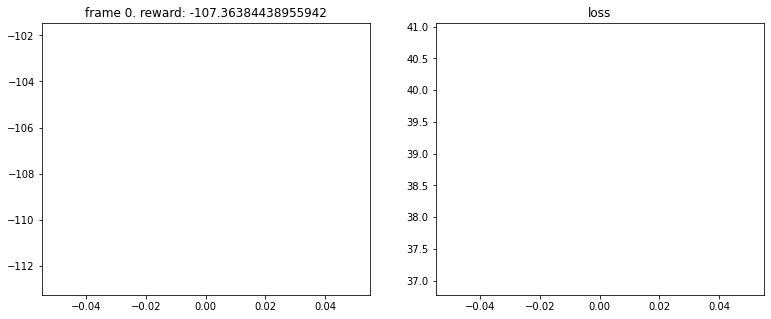

Episode:  1 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-125.96096557888183 1640.4171895980835 48 True
--------------------------------------------------
Episode:  2 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-235.70761364668962 2978.3941242231376 82 True
--------------------------------------------------
Episode:  3 
 --------------------------------------------------
-317.0475263314275 4746.962350845337 91 True
--------------------------------------------------
Episode:  4 
 --------------------------------------------------
-130.83801520246428 4224.347988322377 47 True
--------------------------------------------------
Episode:  5 
 --------------------------------------------------
-4.512988325259659 1663.1977443695068 50 True
--------------------------------------------------
Episode:  6 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-231.81436923907197 1370.3986716270447 41 True
--------------------------------------------------
Episode:  7 
 --------------------------------------------------
-193.9291153541388 3772.810201406479 78 True
--------------------------------------------------
Episode:  8 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-235.0057444814572 2155.520982982591 70 True
--------------------------------------------------
Episode:  9 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-117.73978383299016 1303.69649040699 46 True
--------------------------------------------------
Episode:  10 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-160.96152886712287 1238.6722746007144 41 True
--------------------------------------------------


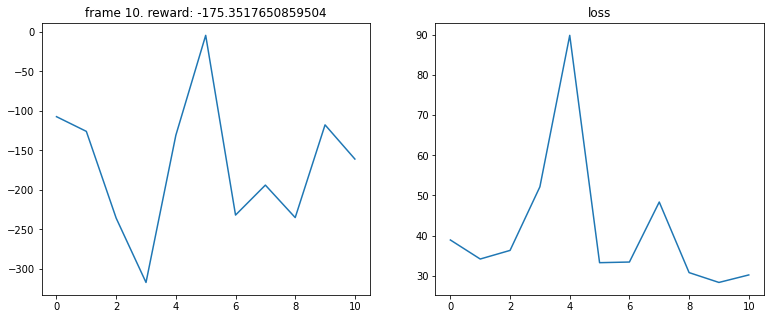

Episode:  11 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-87.56095316428716 2085.801050186157 56 True
--------------------------------------------------
Episode:  12 
 --------------------------------------------------
-165.13137313983898 2532.8597396612167 57 True
--------------------------------------------------
Episode:  13 
 --------------------------------------------------
6.147678830819627 2429.5393903777003 64 True
--------------------------------------------------
Episode:  14 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-352.02320900587677 5498.232961051166 104 True
--------------------------------------------------
Episode:  15 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-169.8230800453124 2262.8121795654297 43 True
--------------------------------------------------
Episode:  16 
 --------------------------------------------------
-134.88206678005508 2325.333306642073 66 True
--------------------------------------------------
Episode:  17 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-159.70339616576877 1820.0136337280273 63 True
--------------------------------------------------
Episode:  18 
 --------------------------------------------------
-12.931482030478595 1003.9315016120672 47 True
--------------------------------------------------
Episode:  19 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-79.15031109396057 1599.9735283851624 67 True
--------------------------------------------------
Episode:  20 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-550.4376172240891 14822.076632483397 210 True
--------------------------------------------------


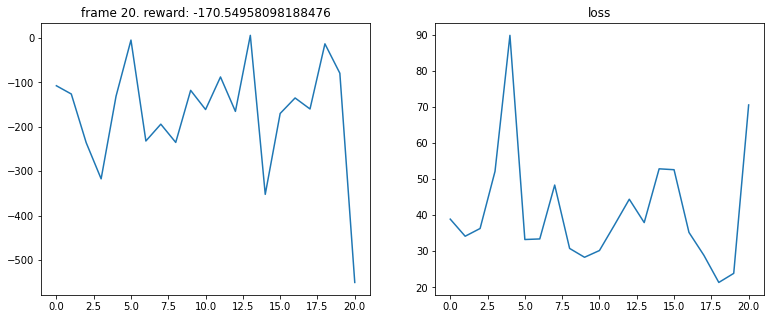

Episode:  21 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-71.49557821431378 3489.639391899109 36 True
--------------------------------------------------
Episode:  22 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-65.46173784385651 2224.9421949386597 62 True
--------------------------------------------------
Episode:  23 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-120.36459134039801 1528.5996067523956 58 True
--------------------------------------------------
Episode:  24 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-59.91119379815893 943.3988342285156 49 True
--------------------------------------------------
Episode:  25 
 --------------------------------------------------
-16.117799383125195 1356.787940979004 37 True
--------------------------------------------------
Episode:  26 
 --------------------------------------------------
-83.96740253172706 1070.0636389255524 57 True
--------------------------------------------------
Episode:  27 
 --------------------------------------------------
24.90363692141168 1697.9586391448975 48 True
--------------------------------------------------
Episode:  28 
 --------------------------------------------------
-170.30394750732006 2837.7793238162994 114 True
--------------------------------------------------
Episode:  29 
 --------------------------------------------------
7.060798240061384 1236.7809019833803 40 True
--------------------------------------------------
Episode:  30 
 --------------------------------------------------
-12.630204669456374 194

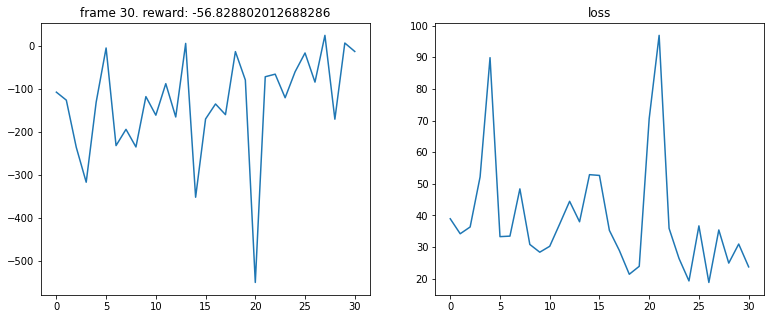

Episode:  31 
 --------------------------------------------------
21.551013981148046 1093.599063038826 60 True
--------------------------------------------------
Episode:  32 
 --------------------------------------------------
-50.487861375850486 860.9822674691677 54 True
--------------------------------------------------
Episode:  33 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-262.9554864904852 2499.9571773707867 74 True
--------------------------------------------------
Episode:  34 
 --------------------------------------------------
42.8868678789481 1756.6847741603851 59 True
--------------------------------------------------
Episode:  35 
 --------------------------------------------------
-89.44116329719952 1007.5066776275635 54 True
--------------------------------------------------
Episode:  36 
 --------------------------------------------------
17.791421844681267 974.1145648956299 40 True
--------------------------------------------------
Episode:  37 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-106.96312802767565 1326.4174757525325 56 True
--------------------------------------------------
Episode:  38 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-196.993309789944 1289.2201039791107 44 True
--------------------------------------------------
Episode:  39 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-147.1955886540548 2378.377035200596 87 True
--------------------------------------------------
Episode:  40 
 --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-144.9955397304604 1320.9690754637122 45 True
--------------------------------------------------


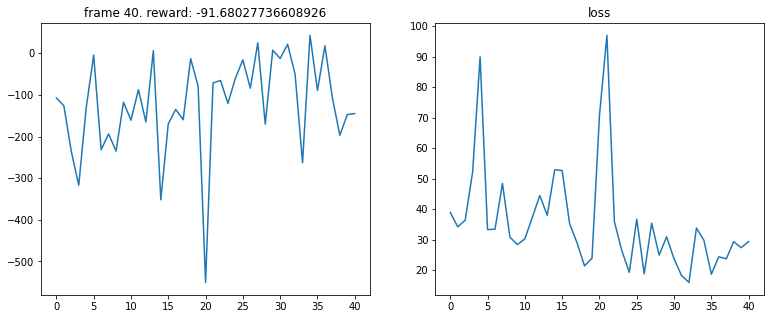

Episode:  41 
 --------------------------------------------------
-15.898949216623299 1305.801622748375 43 True
--------------------------------------------------
Episode:  42 
 --------------------------------------------------


In [ ]:
losses = []
all_rewards = []
for a in range(100):
    print("Episode: ",a,"\n","-"*50)

    TotalReward,TotalLoss,iter,done = run_episode(print_debug=0)
    print(TotalReward,TotalLoss,iter,done )
    
  
    all_rewards.append(TotalReward)
    losses.append(TotalLoss/iter)
    print("-"*50)
    if  a % TARGET_UPDATE*5 == 0:
#         ipythondisplay.clear_output(wait=True)
        pickle.dump(policy_net, open(f"model.pkl", "wb"))
        plot(a, all_rewards, losses)


In [ ]:
env.close()
show_video()

In [ ]:
print(iter)

In [ ]:
#Draw random samples from a normal (Gaussian) distribution.
mu, sigma = 0, 0.05 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
print(s)